# Research Experiments: Answering Open Questions

Numerical experiments to test hypotheses from `docs/research_questions.md`.

## Experiments
1. **Distribution Analysis** — Kurtosis, skewness, Gaussianity per dimension
2. **Median Offset Prediction** — Does ||m||² predict when median centering helps?
3. **Bootstrap Confidence Intervals** — Is Lloyd-Max > float32 significant?
4. **Correlation Structure** — PCA vs Matryoshka dimension ordering
5. **MSE vs Ranking** — Kendall's tau: does lower MSE always mean better NDCG?
6. **Calibration-Free 2-bit** — Fixed boundaries vs Lloyd-Max

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import json
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 5)

CACHE = Path('cache/embeddings')

MODELS = {
    'mxbai': ('mxbai-embed-large-v1', 1024, [1024, 512, 256, 128, 64]),
    'nomic': ('nomic-embed-text-v1.5', 768, [768, 512, 256, 128, 64]),
    'minilm': ('all-MiniLM-L6-v2', 384, [384]),
}

DATASETS = ['SciFact', 'NFCorpus']

def load_emb(model_name, dataset, split='corpus'):
    path = CACHE / f'{model_name}_{dataset}_{split}.npy'
    return np.load(path)

def truncate_normalize(emb, dim):
    t = emb[:, :dim].copy()
    norms = np.linalg.norm(t, axis=1, keepdims=True)
    return t / np.where(norms == 0, 1.0, norms)

print('Setup complete.')

Setup complete.


---
## Experiment 1: Per-Dimension Distribution Analysis

**Question**: Are embedding dimensions Gaussian? If not, Lloyd-Max constants are suboptimal.

We compute per-dimension:
- **Kurtosis** (Gaussian = 3.0; >3 = heavy tails, <3 = light tails)
- **Skewness** (Gaussian = 0; ≠0 = asymmetric)
- **Shapiro-Wilk test** (fraction of dims that reject Gaussian at p<0.05)
- **Median offset** |median| (how far from zero-centered)

In [2]:
def analyze_distribution(emb, label='', max_dims_for_shapiro=200):
    """Compute distribution statistics per dimension."""
    n, d = emb.shape
    
    kurtoses = stats.kurtosis(emb, axis=0, fisher=False)  # Fisher=False → Gaussian=3
    skewnesses = stats.skew(emb, axis=0)
    medians = np.median(emb, axis=0)
    stds = np.std(emb, axis=0)
    
    # Shapiro-Wilk on a sample of dims (expensive)
    test_dims = min(d, max_dims_for_shapiro)
    dim_indices = np.linspace(0, d-1, test_dims, dtype=int)
    n_reject = 0
    for j in dim_indices:
        # Subsample for Shapiro (max 5000)
        sample = emb[np.random.choice(n, min(n, 5000), replace=False), j]
        _, p = stats.shapiro(sample)
        if p < 0.05:
            n_reject += 1
    
    results = {
        'kurtosis_mean': np.mean(kurtoses),
        'kurtosis_std': np.std(kurtoses),
        'kurtosis_range': (np.min(kurtoses), np.max(kurtoses)),
        'skewness_mean': np.mean(np.abs(skewnesses)),
        'skewness_std': np.std(skewnesses),
        'median_offset_rms': np.sqrt(np.mean(medians**2)),
        'median_offset_max': np.max(np.abs(medians)),
        'std_mean': np.mean(stds),
        'std_cv': np.std(stds) / np.mean(stds),  # coefficient of variation
        'shapiro_reject_frac': n_reject / test_dims,
        'kurtoses': kurtoses,
        'skewnesses': skewnesses,
        'medians': medians,
        'stds': stds,
    }
    return results

# Run analysis for all models × datasets × Matryoshka dims
print(f"{'Model':<10} {'Dataset':<10} {'Dim':>5} {'Kurt µ':>7} {'Kurt σ':>7} "
      f"{'|Skew| µ':>8} {'|Med| RMS':>9} {'Std CV':>7} {'Shapiro rej':>11}")
print('─' * 90)

all_results = {}
for mkey, (mname, full_dim, mat_dims) in MODELS.items():
    for ds in DATASETS:
        corpus = load_emb(mname, ds, 'corpus')
        for dim in mat_dims:
            emb = truncate_normalize(corpus, dim)
            r = analyze_distribution(emb, f'{mkey}/{ds}/d={dim}')
            all_results[(mkey, ds, dim)] = r
            print(f"{mkey:<10} {ds:<10} {dim:>5} {r['kurtosis_mean']:>7.2f} {r['kurtosis_std']:>7.2f} "
                  f"{r['skewness_mean']:>8.3f} {r['median_offset_rms']:>9.4f} "
                  f"{r['std_cv']:>7.3f} {r['shapiro_reject_frac']:>10.1%}")

Model      Dataset      Dim  Kurt µ  Kurt σ |Skew| µ |Med| RMS  Std CV Shapiro rej
──────────────────────────────────────────────────────────────────────────────────────────
mxbai      SciFact     1024    3.00    0.12    0.088    0.0228   0.087      55.0%
mxbai      SciFact      512    2.99    0.12    0.084    0.0312   0.085      52.5%
mxbai      SciFact      256    2.98    0.13    0.092    0.0441   0.081      62.0%
mxbai      SciFact      128    2.98    0.14    0.094    0.0622   0.086      58.6%
mxbai      SciFact       64    2.94    0.15    0.095    0.0865   0.084      56.2%
mxbai      NFCorpus    1024    3.08    0.15    0.114    0.0242   0.079      60.5%
mxbai      NFCorpus     512    3.09    0.15    0.121    0.0335   0.082      63.0%
mxbai      NFCorpus     256    3.08    0.14    0.126    0.0471   0.077      67.5%
mxbai      NFCorpus     128    3.06    0.14    0.121    0.0665   0.075      64.8%
mxbai      NFCorpus      64    3.06    0.13    0.131    0.0940   0.074      57.8%
nomic 

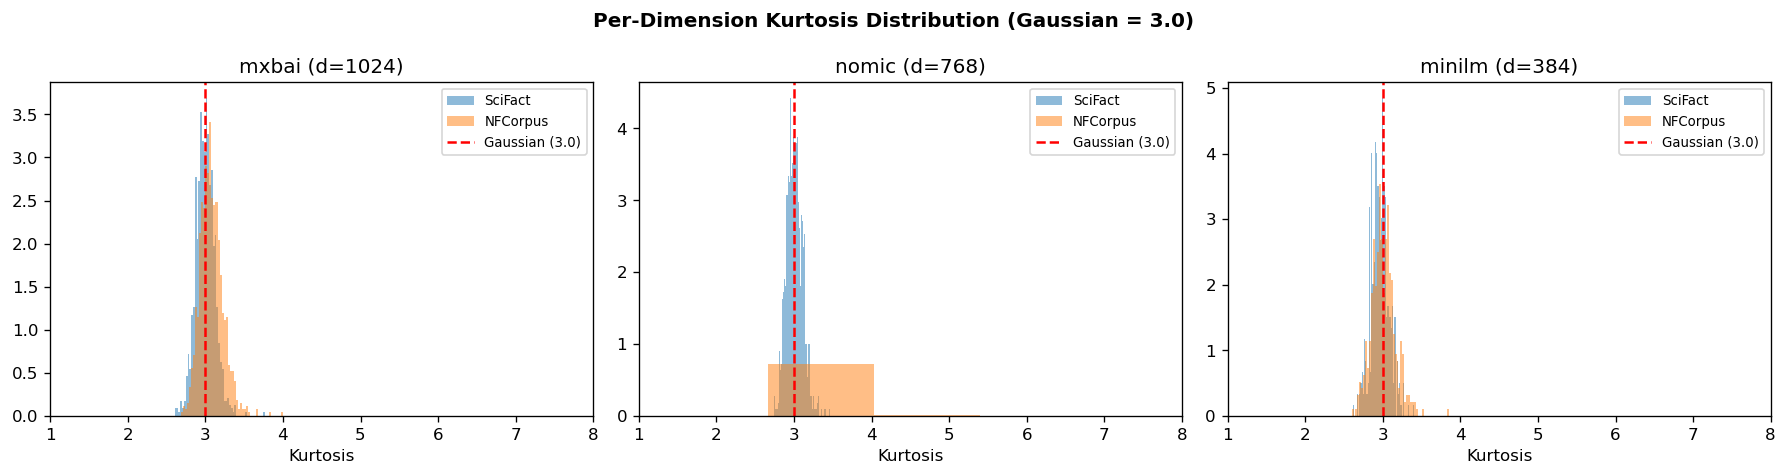

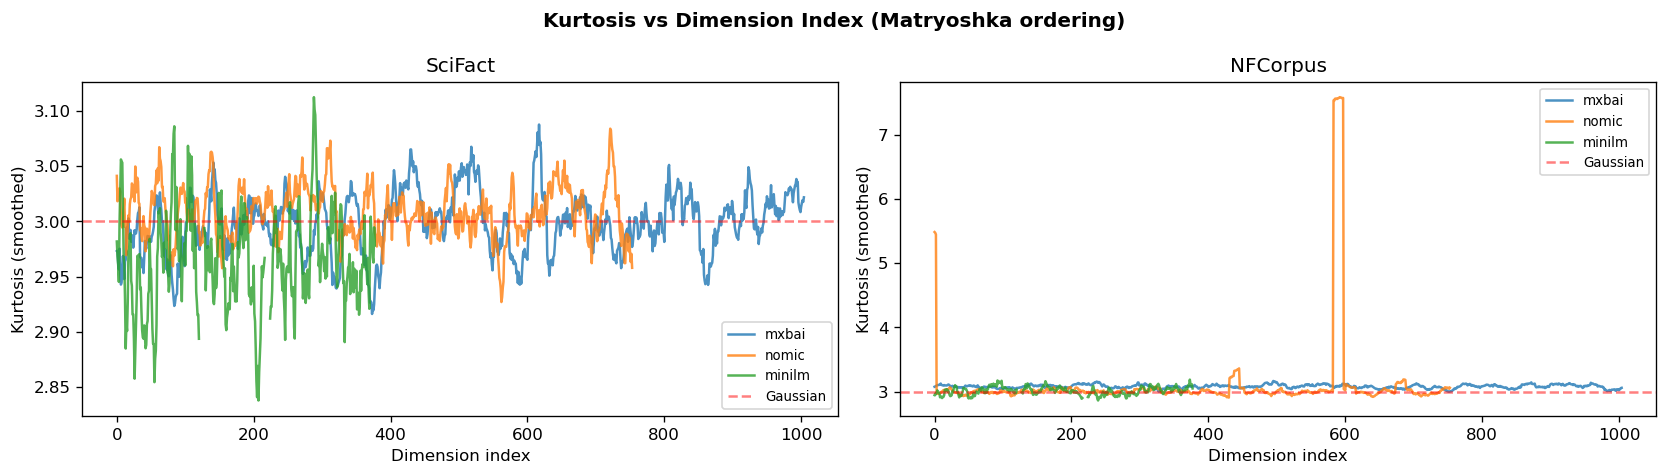

In [3]:
# Visualize kurtosis distribution per model at full dim
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Per-Dimension Kurtosis Distribution (Gaussian = 3.0)', fontweight='bold')

for ax, (mkey, (mname, full_dim, _)) in zip(axes, MODELS.items()):
    for ds in DATASETS:
        r = all_results.get((mkey, ds, full_dim))
        if r:
            ax.hist(r['kurtoses'], bins=50, alpha=0.5, label=ds, density=True)
    ax.axvline(3.0, color='red', linestyle='--', label='Gaussian (3.0)')
    ax.set_title(f'{mkey} (d={full_dim})')
    ax.set_xlabel('Kurtosis')
    ax.legend(fontsize=8)
    ax.set_xlim(1, 8)

plt.tight_layout()
plt.show()

# Kurtosis vs dimension index (does it change across Matryoshka ordering?)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Kurtosis vs Dimension Index (Matryoshka ordering)', fontweight='bold')

for ax, ds in zip(axes, DATASETS):
    for mkey, (mname, full_dim, _) in MODELS.items():
        r = all_results.get((mkey, ds, full_dim))
        if r:
            # Smooth with rolling window
            k = r['kurtoses']
            window = max(1, len(k) // 50)
            smoothed = np.convolve(k, np.ones(window)/window, mode='valid')
            ax.plot(smoothed, label=f'{mkey}', alpha=0.8)
    ax.axhline(3.0, color='red', linestyle='--', alpha=0.5, label='Gaussian')
    ax.set_xlabel('Dimension index')
    ax.set_ylabel('Kurtosis (smoothed)')
    ax.set_title(ds)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

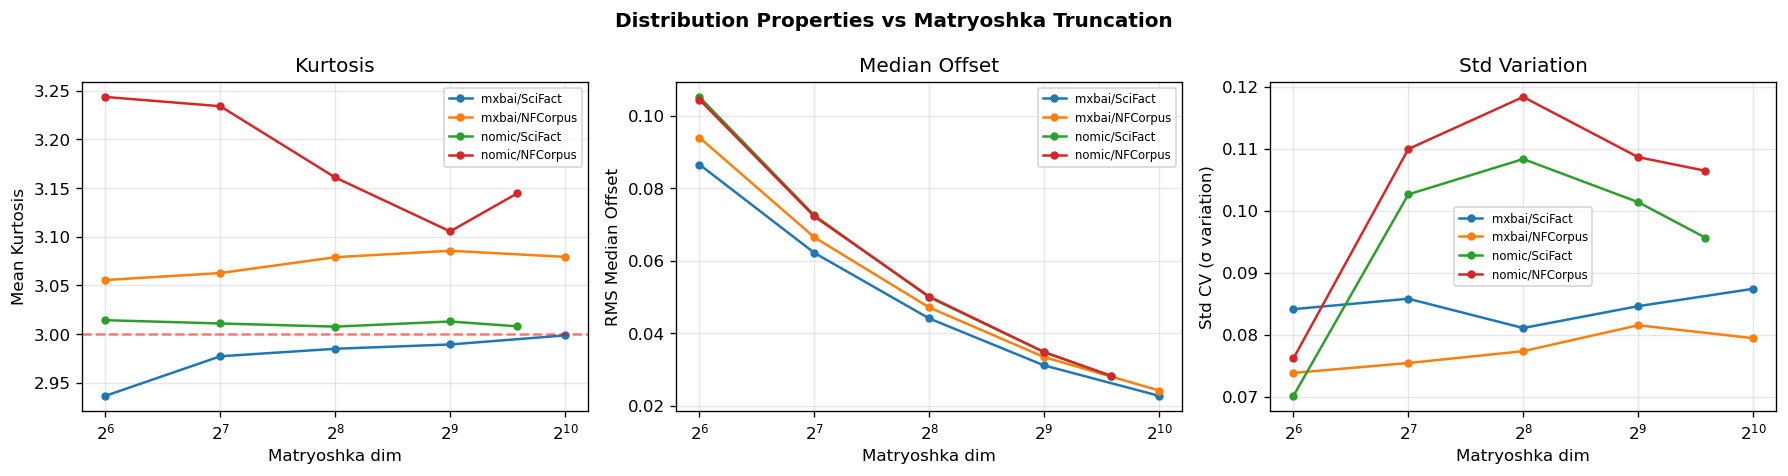

In [4]:
# How kurtosis and median offset change with Matryoshka truncation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Distribution Properties vs Matryoshka Truncation', fontweight='bold')

for mkey, (mname, full_dim, mat_dims) in MODELS.items():
    if len(mat_dims) <= 1:
        continue
    for ds in DATASETS:
        kurt_means = [all_results[(mkey, ds, d)]['kurtosis_mean'] for d in mat_dims]
        med_rms = [all_results[(mkey, ds, d)]['median_offset_rms'] for d in mat_dims]
        std_cv = [all_results[(mkey, ds, d)]['std_cv'] for d in mat_dims]
        
        axes[0].plot(mat_dims, kurt_means, 'o-', label=f'{mkey}/{ds}', markersize=4)
        axes[1].plot(mat_dims, med_rms, 'o-', label=f'{mkey}/{ds}', markersize=4)
        axes[2].plot(mat_dims, std_cv, 'o-', label=f'{mkey}/{ds}', markersize=4)

axes[0].axhline(3.0, color='red', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Mean Kurtosis'); axes[0].set_title('Kurtosis')
axes[1].set_ylabel('RMS Median Offset'); axes[1].set_title('Median Offset')
axes[2].set_ylabel('Std CV (σ variation)'); axes[2].set_title('Std Variation')

for ax in axes:
    ax.set_xlabel('Matryoshka dim')
    ax.set_xscale('log', base=2)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Experiment 2: Median Offset Predicts Centering Benefit

**Hypothesis**: The NDCG improvement from `binary_median_asym` over `binary_asym` is predicted by the RMS median offset ||m||²/d of the embedding distribution.

We compute both quantities for each model × dataset × dim and check the correlation.

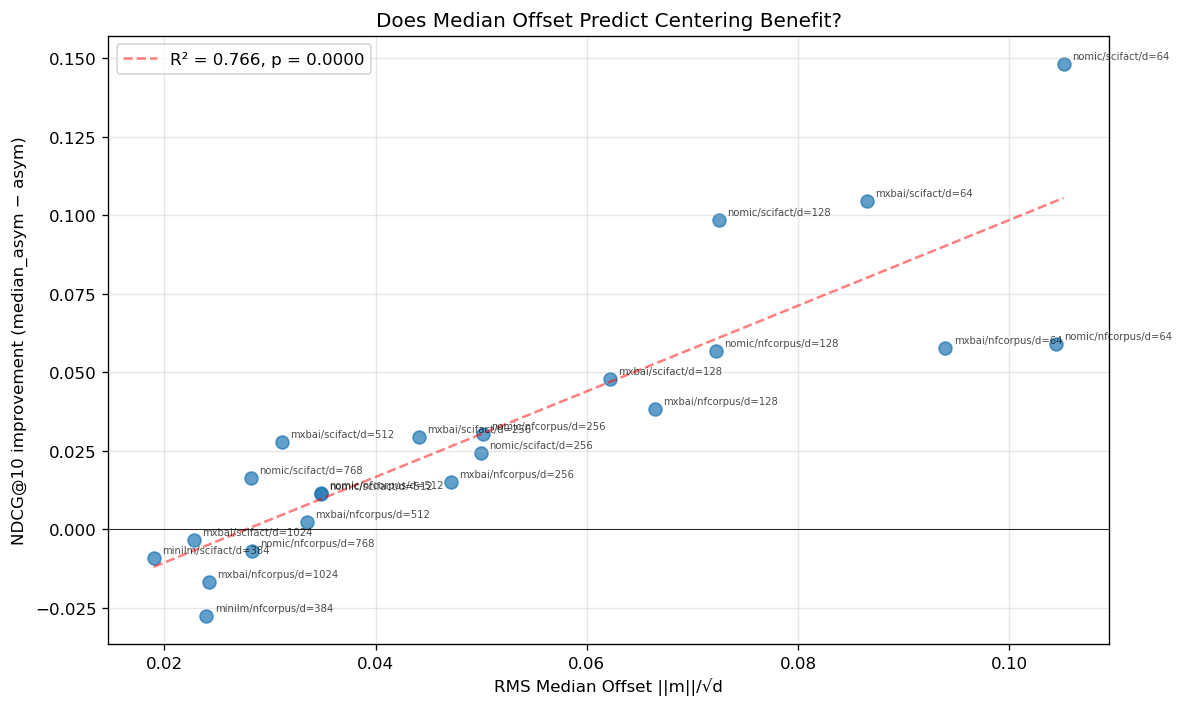


Correlation: R² = 0.766, p-value = 0.0000
Interpretation: Strong predictor


In [5]:
# Load results that have both binary_asym and binary_median_asym
result_files = [
    'results/minilm+mxbai+nomic_scif_rot-had/results.json',
    'results/minilm+mxbai+nomic_nfco_rot-had/results.json',
]

all_exp_results = []
for rf in result_files:
    p = Path(rf)
    if p.exists():
        with open(p) as f:
            data = json.load(f)
            all_exp_results.extend(data.get('results', data))

# Build lookup: (model, dataset, quant, dim, rotation) -> ndcg@10
ndcg_lookup = {}
for r in all_exp_results:
    key = (r['model'], r['dataset'], r['quantization'], r['matryoshka_dim'], r.get('rotation', 'none'))
    ndcg_lookup[key] = r['metrics'].get('ndcg@10', 0)

# Compute centering benefit vs median offset
MODEL_MAP = {
    'mxbai-embed-large-v1': ('mxbai', 'mxbai-embed-large-v1'),
    'nomic-embed-text-v1.5': ('nomic', 'nomic-embed-text-v1.5'),
    'all-MiniLM-L6-v2': ('minilm', 'all-MiniLM-L6-v2'),
}
DS_MAP = {'scifact': 'SciFact', 'nfcorpus': 'NFCorpus'}

points = []  # (median_offset_rms, ndcg_improvement, label)

for model_key, (mkey, mname) in MODEL_MAP.items():
    for ds_key, ds_name in DS_MAP.items():
        _, _, mat_dims = MODELS[mkey]
        for dim in mat_dims:
            # Get NDCG for both methods (rotation=none)
            ndcg_asym = ndcg_lookup.get((model_key, ds_key, 'binary_asym', dim, 'none'))
            ndcg_med = ndcg_lookup.get((model_key, ds_key, 'binary_median_asym', dim, 'none'))
            
            if ndcg_asym is not None and ndcg_med is not None:
                # Get median offset from distribution analysis
                dist_key = (mkey, ds_name, dim)
                if dist_key in all_results:
                    med_rms = all_results[dist_key]['median_offset_rms']
                    improvement = ndcg_med - ndcg_asym
                    points.append((med_rms, improvement, f'{mkey}/{ds_key}/d={dim}'))

if points:
    x = np.array([p[0] for p in points])
    y = np.array([p[1] for p in points])
    labels = [p[2] for p in points]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(x, y, s=60, alpha=0.7)
    
    for xi, yi, label in zip(x, y, labels):
        ax.annotate(label, (xi, yi), fontsize=6, textcoords='offset points',
                   xytext=(5, 3), alpha=0.7)
    
    # Fit linear regression
    if len(x) > 2:
        slope, intercept, r_value, p_value, _ = stats.linregress(x, y)
        x_fit = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_fit, slope * x_fit + intercept, 'r--', alpha=0.5,
               label=f'R² = {r_value**2:.3f}, p = {p_value:.4f}')
    
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('RMS Median Offset ||m||/√d')
    ax.set_ylabel('NDCG@10 improvement (median_asym − asym)')
    ax.set_title('Does Median Offset Predict Centering Benefit?')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f'\nCorrelation: R² = {r_value**2:.3f}, p-value = {p_value:.4f}')
    print(f'Interpretation: {"Strong" if r_value**2 > 0.5 else "Weak"} predictor')
else:
    print('No matching data points found — check result file paths')

---
## Experiment 3: Bootstrap Confidence Intervals

**Question**: Is Lloyd-Max > float32 statistically significant, or noise?

Resample queries with replacement 2000 times, compute NDCG@10 each time.

In [6]:
from data_loader import MTEBDataLoader
from metrics import RetrievalMetrics

data_loader = MTEBDataLoader(Path('cache/datasets'))

# Helper functions from hypothesis_tests
def search_topk(scores, k):
    k = min(k, scores.shape[1])
    indices = np.argpartition(-scores, k, axis=1)[:, :k]
    for i in range(len(indices)):
        idx = indices[i]
        indices[i] = idx[np.argsort(-scores[i, idx])]
    return indices

def packbits(emb):
    return np.packbits((emb > 0).astype(np.uint8), axis=1)

def unpack_pm1(binary, dim):
    unpacked = np.unpackbits(binary, axis=1)[:, :dim].astype(np.float32)
    return 2.0 * unpacked - 1.0

LLOYD_BOUNDS = np.array([-0.9816, 0.0, 0.9816])
LLOYD_LEVELS = np.array([-1.5104, -0.4528, 0.4528, 1.5104], dtype=np.float32)

def get_scores_float32(q, c):
    return q @ c.T

def get_scores_lloyd_max(q, c):
    medians = np.median(c, axis=0)
    stds = np.std(c, axis=0).clip(1e-10)
    z = (c - medians) / stds
    codes = np.digitize(z, LLOYD_BOUNDS)
    recon_z = LLOYD_LEVELS[codes]
    q_scaled = q * stds
    return q_scaled @ recon_z.T

def get_scores_binary_asym(q, c):
    binary = packbits(c)
    unpacked = unpack_pm1(binary, c.shape[1])
    return q @ unpacked.T

def get_scores_binary_median_asym(q, c):
    medians = np.median(c, axis=0)
    binary = packbits(c - medians)
    unpacked = unpack_pm1(binary, c.shape[1])
    return (q - medians) @ unpacked.T

def get_scores_int8_asym(q, c):
    from sentence_transformers.quantization import quantize_embeddings
    c_int8 = quantize_embeddings(c, precision='int8')
    return q @ c_int8.astype(np.float32).T

def get_scores_quaternary_asym(q, c):
    boundaries = np.percentile(c, [25, 50, 75], axis=0).astype(np.float32)
    codes = np.zeros_like(c, dtype=np.uint8)
    codes[c >= boundaries[0]] = 1
    codes[c >= boundaries[1]] = 2
    codes[c >= boundaries[2]] = 3
    dim = c.shape[1]
    centroids = np.zeros((4, dim), dtype=np.float32)
    for cv in range(4):
        mask = (codes == cv)
        for j in range(dim):
            col_mask = mask[:, j]
            if col_mask.any():
                centroids[cv, j] = c[col_mask, j].mean()
    reconstructed = centroids[codes, np.arange(dim)]
    return q @ reconstructed.T

METHODS = {
    'float32': get_scores_float32,
    'lloyd_max_gauss': get_scores_lloyd_max,
    'int8_asym': get_scores_int8_asym,
    'quaternary_asym': get_scores_quaternary_asym,
    'binary_median_asym': get_scores_binary_median_asym,
    'binary_asym': get_scores_binary_asym,
}

print('Methods loaded.')

Methods loaded.


In [7]:
def bootstrap_ndcg(query_emb, corpus_emb, qrels, doc_id_to_idx, query_ids,
                    methods, n_bootstrap=2000, k=10, seed=42):
    """
    Bootstrap NDCG@k: resample queries with replacement.
    Returns dict of method -> array of bootstrapped NDCG values.
    """
    rng = np.random.default_rng(seed)
    n_queries = len(query_ids)
    
    # Pre-compute per-query NDCG for each method
    per_query_ndcg = {}  # method -> (n_queries,) array
    
    for method_name, score_fn in methods.items():
        scores = score_fn(query_emb, corpus_emb)
        indices = search_topk(scores, 100)
        
        # Compute per-query NDCG
        qrels_idx = {}
        for qid in query_ids:
            if qid in qrels:
                qrels_idx[qid] = {
                    doc_id_to_idx[did]: rel
                    for did, rel in qrels[qid].items()
                    if did in doc_id_to_idx
                }
        
        query_ndcgs = []
        for i, qid in enumerate(query_ids):
            if qid not in qrels_idx or len(qrels_idx[qid]) == 0:
                query_ndcgs.append(np.nan)
                continue
            retrieved = indices[i, :k]
            rels = np.array([qrels_idx[qid].get(int(did), 0) for did in retrieved])
            if rels.sum() == 0:
                query_ndcgs.append(0.0)
                continue
            dcg = np.sum(rels / np.log2(np.arange(1, k+1) + 1))
            ideal_rels = sorted(qrels_idx[qid].values(), reverse=True)[:k]
            ideal_rels = np.array(ideal_rels + [0] * (k - len(ideal_rels)))
            idcg = np.sum(ideal_rels / np.log2(np.arange(1, k+1) + 1))
            query_ndcgs.append(dcg / idcg if idcg > 0 else 0.0)
        
        per_query_ndcg[method_name] = np.array(query_ndcgs)
        mean_ndcg = np.nanmean(per_query_ndcg[method_name])
        print(f'  {method_name:<25s} NDCG@{k} = {mean_ndcg:.4f}')
    
    # Bootstrap
    valid_mask = ~np.isnan(per_query_ndcg['float32'])
    valid_indices = np.where(valid_mask)[0]
    n_valid = len(valid_indices)
    
    bootstrap_results = {m: np.zeros(n_bootstrap) for m in methods}
    for b in range(n_bootstrap):
        sample = rng.choice(valid_indices, size=n_valid, replace=True)
        for m in methods:
            bootstrap_results[m][b] = np.mean(per_query_ndcg[m][sample])
    
    return bootstrap_results, per_query_ndcg

print('Bootstrap function ready.')

Bootstrap function ready.


In [8]:
# Run bootstrap for mxbai on SciFact (where Lloyd-Max > float32)
model_name = 'mxbai-embed-large-v1'
dataset = 'SciFact'
ds_key = 'scifact'

corpus_emb = load_emb(model_name, dataset, 'corpus')
query_emb = load_emb(model_name, dataset, 'queries')
corpus_data, queries_data, qrels = data_loader.load_dataset(ds_key)
doc_ids, _, query_ids, _ = data_loader.get_texts_for_embedding(corpus_data, queries_data)
doc_id_to_idx = {did: i for i, did in enumerate(doc_ids)}

print(f'\n=== {model_name} / {dataset} (full dim={corpus_emb.shape[1]}) ===')
bootstrap_mxbai_scifact, pq_mxbai = bootstrap_ndcg(
    query_emb, corpus_emb, qrels, doc_id_to_idx, query_ids, METHODS, n_bootstrap=2000
)

Loading cached scifact from cache/datasets/scifact_data.pkl

=== mxbai-embed-large-v1 / SciFact (full dim=1024) ===
  float32                   NDCG@10 = 0.7389
  lloyd_max_gauss           NDCG@10 = 0.7465
  int8_asym                 NDCG@10 = 0.7348
  quaternary_asym           NDCG@10 = 0.7407
  binary_median_asym        NDCG@10 = 0.7259
  binary_asym               NDCG@10 = 0.7292


In [9]:
# Also run on NFCorpus for comparison
dataset2 = 'NFCorpus'
ds_key2 = 'nfcorpus'

corpus_emb2 = load_emb(model_name, dataset2, 'corpus')
query_emb2 = load_emb(model_name, dataset2, 'queries')
corpus_data2, queries_data2, qrels2 = data_loader.load_dataset(ds_key2)
doc_ids2, _, query_ids2, _ = data_loader.get_texts_for_embedding(corpus_data2, queries_data2)
doc_id_to_idx2 = {did: i for i, did in enumerate(doc_ids2)}

print(f'\n=== {model_name} / {dataset2} (full dim={corpus_emb2.shape[1]}) ===')
bootstrap_mxbai_nfco, pq_mxbai_nfco = bootstrap_ndcg(
    query_emb2, corpus_emb2, qrels2, doc_id_to_idx2, query_ids2, METHODS, n_bootstrap=2000
)

Loading cached nfcorpus from cache/datasets/nfcorpus_data.pkl

=== mxbai-embed-large-v1 / NFCorpus (full dim=1024) ===
  float32                   NDCG@10 = 0.3868
  lloyd_max_gauss           NDCG@10 = 0.3792
  int8_asym                 NDCG@10 = 0.3873
  quaternary_asym           NDCG@10 = 0.3732
  binary_median_asym        NDCG@10 = 0.3559
  binary_asym               NDCG@10 = 0.3730


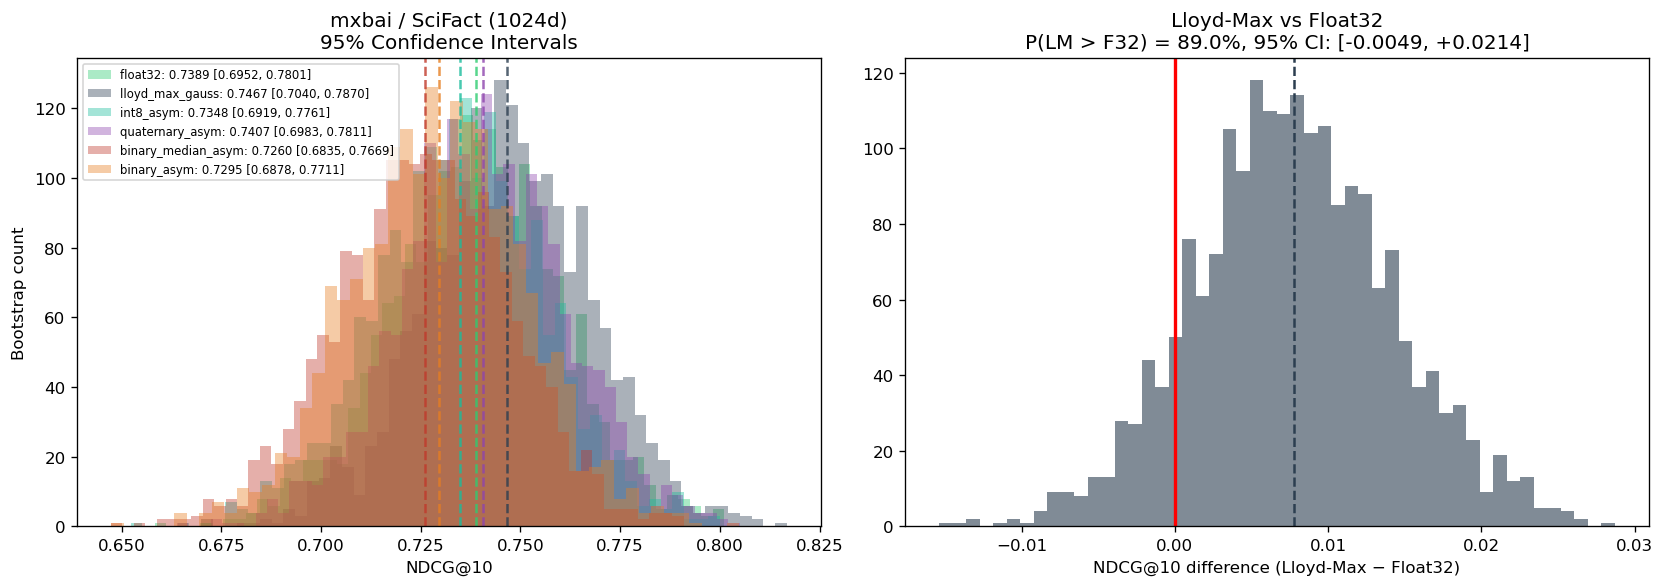

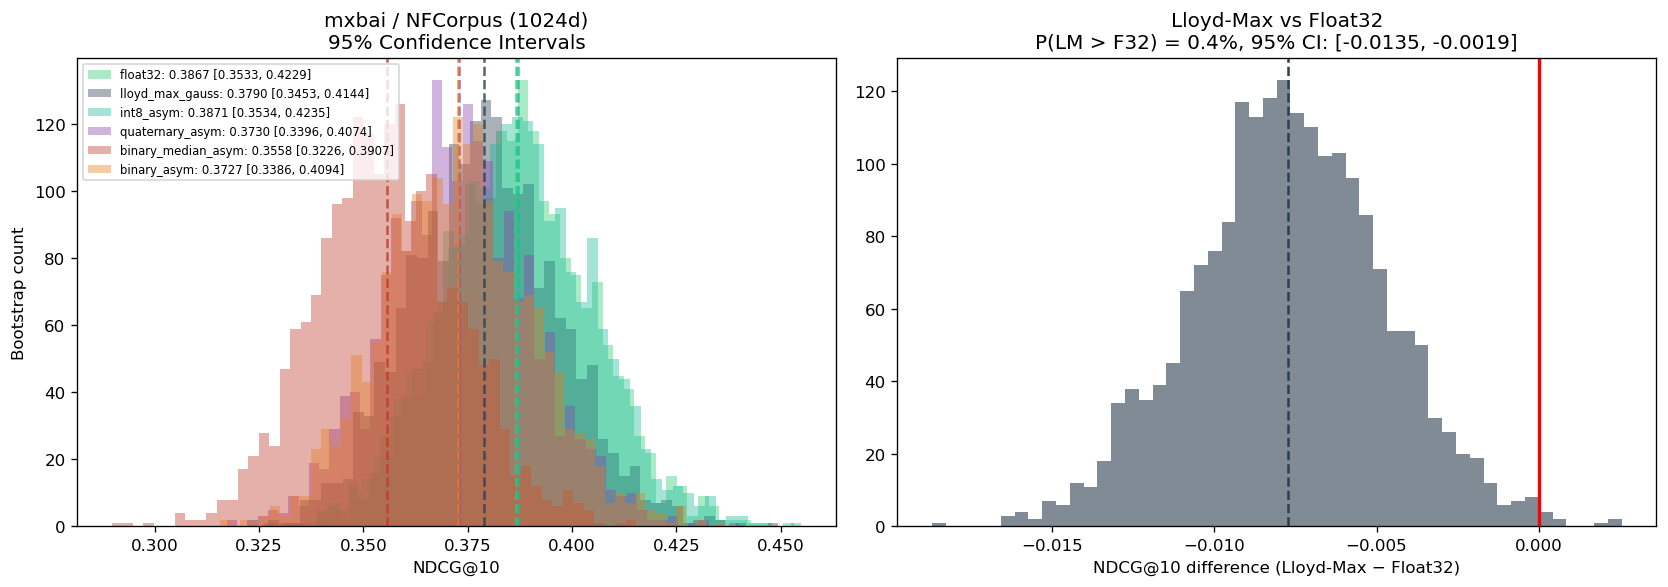

In [10]:
# Plot bootstrap distributions
def plot_bootstrap(bootstrap_results, title, methods_to_compare=None):
    if methods_to_compare is None:
        methods_to_compare = list(bootstrap_results.keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: distributions
    ax = axes[0]
    colors = {'float32': '#2ecc71', 'lloyd_max_gauss': '#2c3e50', 'int8_asym': '#1abc9c',
              'quaternary_asym': '#8e44ad', 'binary_median_asym': '#c0392b', 'binary_asym': '#e67e22'}
    for m in methods_to_compare:
        vals = bootstrap_results[m]
        ci_lo, ci_hi = np.percentile(vals, [2.5, 97.5])
        ax.hist(vals, bins=50, alpha=0.4, color=colors.get(m, 'gray'), label=f'{m}: {np.mean(vals):.4f} [{ci_lo:.4f}, {ci_hi:.4f}]')
        ax.axvline(np.mean(vals), color=colors.get(m, 'gray'), linestyle='--', alpha=0.8)
    ax.set_xlabel('NDCG@10')
    ax.set_ylabel('Bootstrap count')
    ax.set_title(f'{title}\n95% Confidence Intervals')
    ax.legend(fontsize=7)
    
    # Right: pairwise difference (lloyd_max - float32)
    ax = axes[1]
    if 'lloyd_max_gauss' in bootstrap_results and 'float32' in bootstrap_results:
        diff = bootstrap_results['lloyd_max_gauss'] - bootstrap_results['float32']
        ci_lo, ci_hi = np.percentile(diff, [2.5, 97.5])
        frac_positive = np.mean(diff > 0)
        ax.hist(diff, bins=50, alpha=0.6, color='#2c3e50')
        ax.axvline(0, color='red', linestyle='-', linewidth=2)
        ax.axvline(np.mean(diff), color='#2c3e50', linestyle='--')
        ax.set_xlabel('NDCG@10 difference (Lloyd-Max − Float32)')
        ax.set_title(f'Lloyd-Max vs Float32\nP(LM > F32) = {frac_positive:.1%}, 95% CI: [{ci_lo:+.4f}, {ci_hi:+.4f}]')
    
    plt.tight_layout()
    plt.show()

plot_bootstrap(bootstrap_mxbai_scifact, 'mxbai / SciFact (1024d)')
plot_bootstrap(bootstrap_mxbai_nfco, 'mxbai / NFCorpus (1024d)')

---
## Experiment 4: Correlation Structure — PCA vs Matryoshka

**Question**: Do dimensions have significant correlations that scalar quantization misses?

If PCA explains much more variance in k components than the first k Matryoshka dims,
there's inter-dimension redundancy that PQ could exploit.

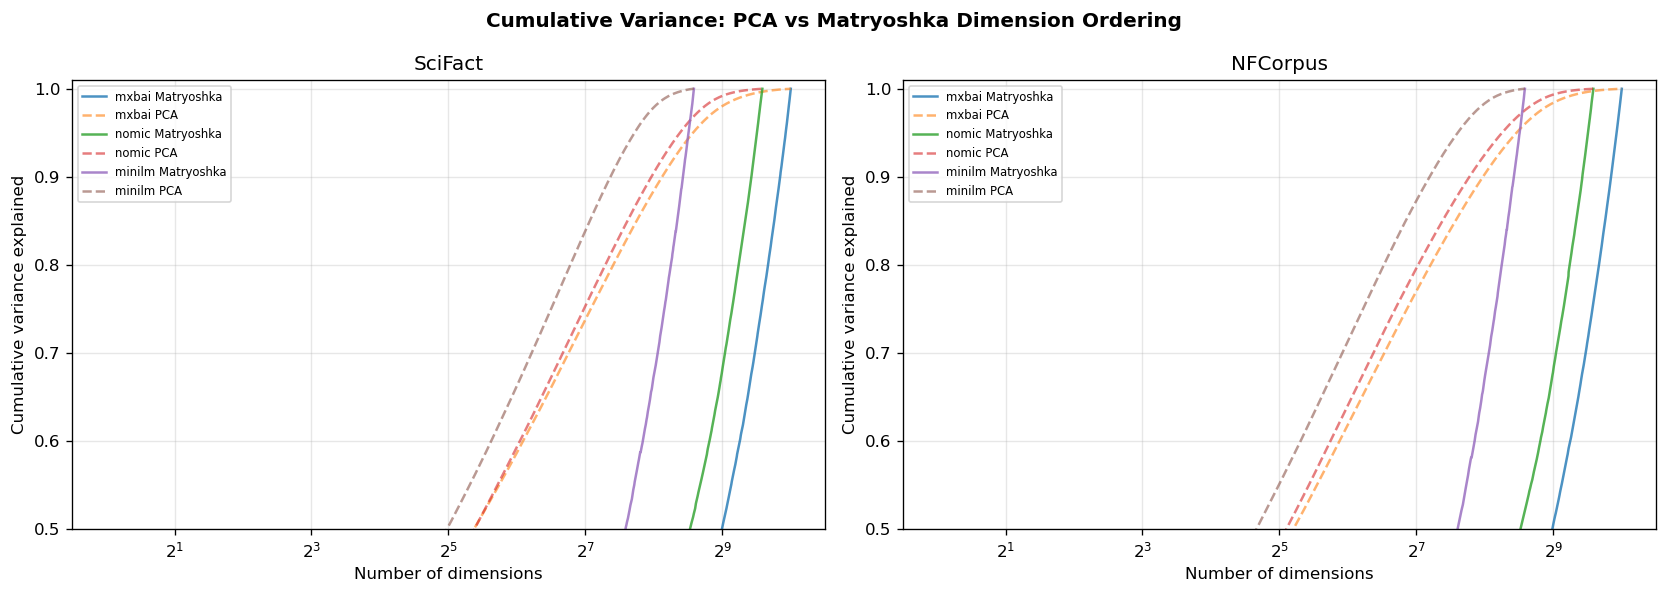


Model      Dataset      Dim  Matryoshka         PCA     Gap
────────────────────────────────────────────────────────────
mxbai      SciFact       64     6.418%    58.646%  52.2%
mxbai      SciFact      128    12.820%    73.772%  61.0%
mxbai      SciFact      256    25.389%    88.437%  63.0%
mxbai      NFCorpus      64     6.266%    61.827%  55.6%
mxbai      NFCorpus     128    12.548%    77.010%  64.5%
mxbai      NFCorpus     256    25.478%    90.317%  64.8%
nomic      SciFact       64    11.747%    59.292%  47.5%
nomic      SciFact      128    20.211%    75.325%  55.1%
nomic      SciFact      256    36.155%    90.475%  54.3%
nomic      NFCorpus      64    12.038%    64.036%  52.0%
nomic      NFCorpus     128    20.619%    79.614%  59.0%
nomic      NFCorpus     256    36.150%    92.534%  56.4%
minilm     SciFact       64    17.301%    66.235%  48.9%
minilm     SciFact      128    33.689%    83.863%  50.2%
minilm     SciFact      256    67.418%    97.901%  30.5%
minilm     NFCorpus    

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Cumulative Variance: PCA vs Matryoshka Dimension Ordering', fontweight='bold')

for ax, ds in zip(axes, DATASETS):
    for mkey, (mname, full_dim, _) in MODELS.items():
        corpus = load_emb(mname, ds, 'corpus')
        
        # Matryoshka ordering: cumulative variance of first k dims
        per_dim_var = np.var(corpus, axis=0)
        total_var = per_dim_var.sum()
        matryoshka_cumvar = np.cumsum(per_dim_var) / total_var
        
        # PCA ordering
        centered = corpus - corpus.mean(axis=0)
        # Use SVD for efficiency (don't need full eigendecomposition)
        _, S, _ = np.linalg.svd(centered, full_matrices=False)
        pca_var = S**2 / (corpus.shape[0] - 1)
        pca_cumvar = np.cumsum(pca_var) / pca_var.sum()
        
        dims = np.arange(1, full_dim + 1)
        ax.plot(dims, matryoshka_cumvar, '-', label=f'{mkey} Matryoshka', alpha=0.8)
        ax.plot(dims, pca_cumvar, '--', label=f'{mkey} PCA', alpha=0.6)
    
    ax.set_xlabel('Number of dimensions')
    ax.set_ylabel('Cumulative variance explained')
    ax.set_title(ds)
    ax.set_xscale('log', base=2)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.5, 1.01)

plt.tight_layout()
plt.show()

# Print the gap at key dims
print(f"\n{'Model':<10} {'Dataset':<10} {'Dim':>5} {'Matryoshka':>11} {'PCA':>11} {'Gap':>7}")
print('─' * 60)
for mkey, (mname, full_dim, _) in MODELS.items():
    for ds in DATASETS:
        corpus = load_emb(mname, ds, 'corpus')
        per_dim_var = np.var(corpus, axis=0)
        total_var = per_dim_var.sum()
        mat_cumvar = np.cumsum(per_dim_var) / total_var
        
        centered = corpus - corpus.mean(axis=0)
        _, S, _ = np.linalg.svd(centered, full_matrices=False)
        pca_var = S**2 / (corpus.shape[0] - 1)
        pca_cumvar = np.cumsum(pca_var) / pca_var.sum()
        
        for dim in [64, 128, 256]:
            if dim < full_dim:
                m_val = mat_cumvar[dim-1]
                p_val = pca_cumvar[dim-1]
                print(f"{mkey:<10} {ds:<10} {dim:>5} {m_val:>10.3%} {p_val:>10.3%} {(p_val-m_val):>6.1%}")

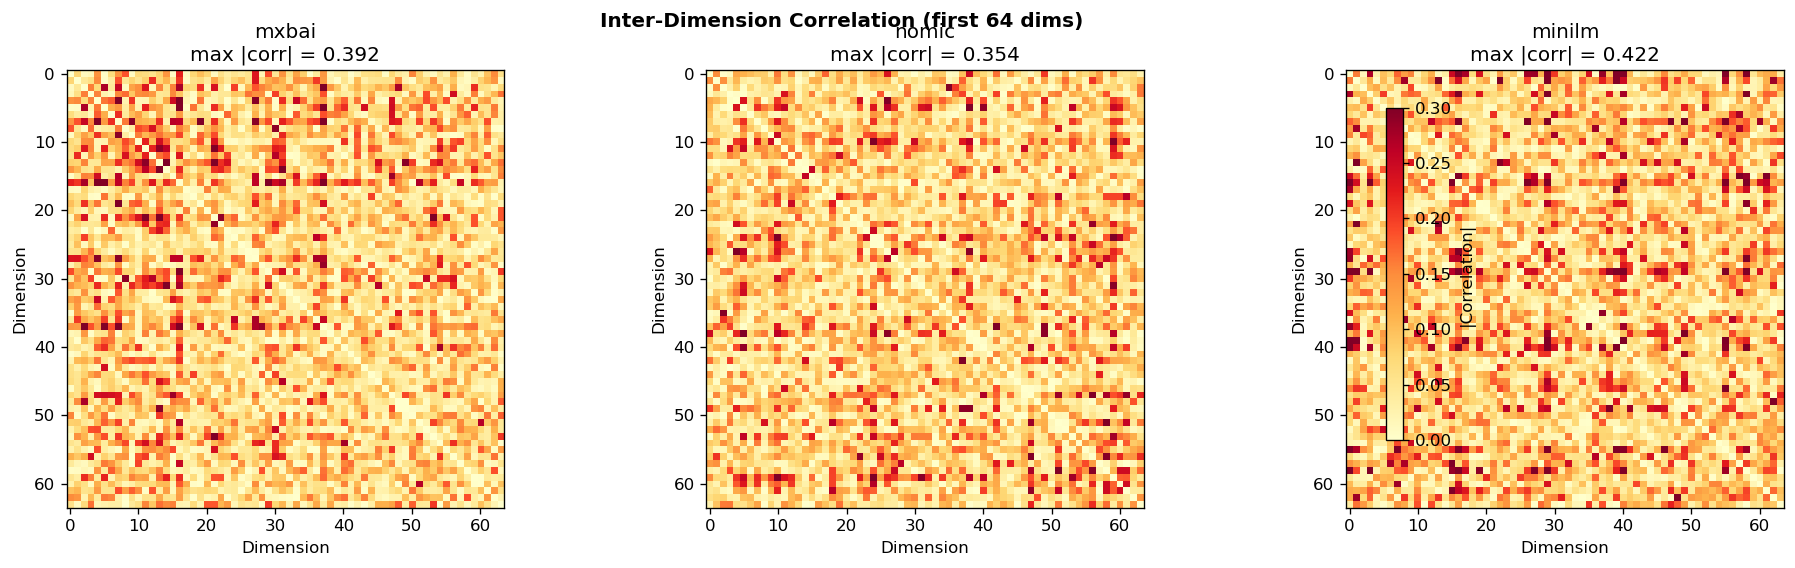


Model      Dataset     Mean |corr|  Max |corr|  Frac |corr|>0.1
─────────────────────────────────────────────────────────────────
mxbai      SciFact          0.0846      0.5277           33.9%
mxbai      NFCorpus         0.0802      0.4681           32.1%
nomic      SciFact          0.0777      0.4757           30.0%
nomic      NFCorpus         0.0787      0.7171           31.0%
minilm     SciFact          0.0840      0.8106           33.7%
minilm     NFCorpus         0.0883      0.7506           36.9%


In [12]:
# Inter-dimension correlation heatmap (first 64 dims)
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
fig.suptitle('Inter-Dimension Correlation (first 64 dims)', fontweight='bold')

for ax, (mkey, (mname, full_dim, _)) in zip(axes, MODELS.items()):
    corpus = load_emb(mname, 'SciFact', 'corpus')
    corr = np.corrcoef(corpus[:, :64].T)  # (64, 64)
    
    # Zero diagonal for visualization
    np.fill_diagonal(corr, 0)
    
    im = ax.imshow(np.abs(corr), cmap='YlOrRd', vmin=0, vmax=0.3)
    ax.set_title(f'{mkey}\nmax |corr| = {np.max(np.abs(corr)):.3f}')
    ax.set_xlabel('Dimension')
    ax.set_ylabel('Dimension')

fig.colorbar(im, ax=axes, label='|Correlation|', shrink=0.8)
plt.tight_layout()
plt.show()

# Summary statistic: mean absolute off-diagonal correlation
print(f"\n{'Model':<10} {'Dataset':<10} {'Mean |corr|':>12} {'Max |corr|':>11} {'Frac |corr|>0.1':>16}")
print('─' * 65)
for mkey, (mname, full_dim, _) in MODELS.items():
    for ds in DATASETS:
        corpus = load_emb(mname, ds, 'corpus')
        corr = np.corrcoef(corpus.T)
        np.fill_diagonal(corr, 0)
        abs_corr = np.abs(corr)
        n = corr.shape[0]
        n_pairs = n * (n - 1) / 2
        upper = abs_corr[np.triu_indices(n, k=1)]
        print(f"{mkey:<10} {ds:<10} {np.mean(upper):>12.4f} {np.max(upper):>11.4f} {np.mean(upper > 0.1):>15.1%}")

---
## Experiment 5: MSE vs Ranking Quality

**Question**: Does lower reconstruction MSE always mean better NDCG?

Compute both MSE and NDCG@10 for each method × dim, then plot correlation.

In [13]:
def compute_score_mse_and_rank_corr(query_emb, corpus_emb, score_fn):
    """Compute MSE of scores and Kendall's tau rank correlation vs float32."""
    # Ground truth scores
    gt_scores = query_emb @ corpus_emb.T  # (n_q, n_c)
    
    # Quantized scores
    q_scores = score_fn(query_emb, corpus_emb)
    
    # Score MSE (averaged over queries)
    score_mse = np.mean((gt_scores - q_scores)**2)
    
    # Rank correlation: for each query, compare top-100 ranking
    taus = []
    n_queries = min(query_emb.shape[0], 50)  # subsample for speed
    for i in range(n_queries):
        # Get top-100 by ground truth
        gt_top = np.argsort(-gt_scores[i])[:100]
        # Rank these docs by quantized scores
        gt_ranking = np.argsort(-gt_scores[i, gt_top])
        q_ranking = np.argsort(-q_scores[i, gt_top])
        tau, _ = stats.kendalltau(gt_ranking, q_ranking)
        if not np.isnan(tau):
            taus.append(tau)
    
    mean_tau = np.mean(taus) if taus else 0.0
    return score_mse, mean_tau

# Run for multiple dims and methods
print(f"{'Model':<10} {'Dataset':<10} {'Dim':>5} {'Method':<25} {'Score MSE':>10} {'Kendall τ':>10}")
print('─' * 80)

mse_ndcg_points = []  # (score_mse, kendall_tau, ndcg, method, model, dataset, dim)

for mkey, (mname, full_dim, mat_dims) in MODELS.items():
    for ds_label, ds_key in [('SciFact', 'scifact'), ('NFCorpus', 'nfcorpus')]:
        ds_name = 'SciFact' if ds_key == 'scifact' else 'NFCorpus'
        corpus_full = load_emb(mname, ds_name, 'corpus')
        query_full = load_emb(mname, ds_name, 'queries')
        
        for dim in [full_dim, 256] if full_dim > 256 else [full_dim]:
            corpus = truncate_normalize(corpus_full, dim)
            queries = truncate_normalize(query_full, dim)
            
            for method_name, score_fn in METHODS.items():
                if method_name == 'float32':
                    continue  # reference, MSE=0
                
                mse, tau = compute_score_mse_and_rank_corr(queries, corpus, score_fn)
                
                # Get NDCG from stored results
                model_key = mname.split('/')[-1] if '/' in mname else mname
                ndcg = ndcg_lookup.get((model_key, ds_key, method_name, dim, 'none'), None)
                
                mse_ndcg_points.append((mse, tau, ndcg, method_name, mkey, ds_key, dim))
                print(f"{mkey:<10} {ds_label:<10} {dim:>5} {method_name:<25} {mse:>10.6f} {tau:>10.4f}")

Model      Dataset      Dim Method                     Score MSE  Kendall τ
────────────────────────────────────────────────────────────────────────────────
mxbai      SciFact     1024 lloyd_max_gauss             0.251982     0.7433
mxbai      SciFact     1024 int8_asym                 11270.543945     0.9156
mxbai      SciFact     1024 quaternary_asym             0.000131     0.7034
mxbai      SciFact     1024 binary_median_asym          3.966769     0.5363
mxbai      SciFact     1024 binary_asym               141.708115     0.5637
mxbai      SciFact      256 lloyd_max_gauss             0.222702     0.5879
mxbai      SciFact      256 int8_asym                 3470.219482     0.8646
mxbai      SciFact      256 quaternary_asym             0.000341     0.5604
mxbai      SciFact      256 binary_median_asym          1.538111     0.4334
mxbai      SciFact      256 binary_asym                33.078709     0.3975
mxbai      NFCorpus    1024 lloyd_max_gauss             0.252051     0.7285
mxba

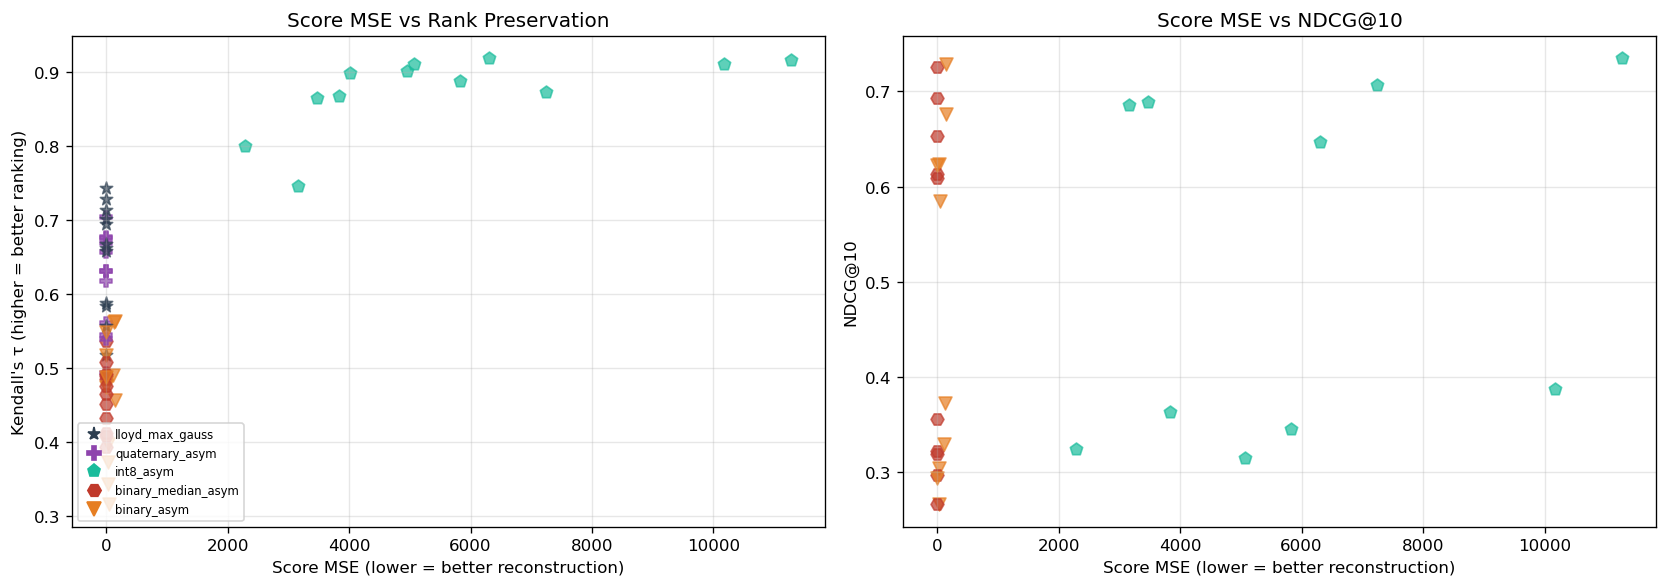


Correlation (MSE vs τ): r = 0.738, p = 0.0000
Interpretation: MSE is a reliable proxy for ranking quality


In [14]:
# Plot MSE vs Kendall's tau
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

method_colors = {
    'lloyd_max_gauss': '#2c3e50', 'quaternary_asym': '#8e44ad',
    'int8_asym': '#1abc9c', 'binary_median_asym': '#c0392b', 'binary_asym': '#e67e22'
}
method_markers = {
    'lloyd_max_gauss': '*', 'quaternary_asym': 'P',
    'int8_asym': 'p', 'binary_median_asym': 'H', 'binary_asym': 'v'
}

# Left: Score MSE vs Kendall's tau
ax = axes[0]
for mse, tau, ndcg, method, model, ds, dim in mse_ndcg_points:
    ax.scatter(mse, tau, c=method_colors.get(method, 'gray'),
              marker=method_markers.get(method, 'o'), s=60, alpha=0.7)
ax.set_xlabel('Score MSE (lower = better reconstruction)')
ax.set_ylabel("Kendall's τ (higher = better ranking)")
ax.set_title('Score MSE vs Rank Preservation')
ax.grid(True, alpha=0.3)

# Right: Score MSE vs NDCG (where available)
ax = axes[1]
for mse, tau, ndcg, method, model, ds, dim in mse_ndcg_points:
    if ndcg is not None:
        ax.scatter(mse, ndcg, c=method_colors.get(method, 'gray'),
                  marker=method_markers.get(method, 'o'), s=60, alpha=0.7)
ax.set_xlabel('Score MSE (lower = better reconstruction)')
ax.set_ylabel('NDCG@10')
ax.set_title('Score MSE vs NDCG@10')
ax.grid(True, alpha=0.3)

# Shared legend
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker=method_markers[m], color=method_colors[m],
                  linestyle='None', markersize=8, label=m)
          for m in method_colors]
axes[0].legend(handles=handles, fontsize=7, loc='lower left')

plt.tight_layout()
plt.show()

# Correlation between MSE and tau
mses = [p[0] for p in mse_ndcg_points]
taus = [p[1] for p in mse_ndcg_points]
r, p = stats.pearsonr(mses, taus)
print(f'\nCorrelation (MSE vs τ): r = {r:.3f}, p = {p:.4f}')
print(f'Interpretation: MSE {"is" if abs(r) > 0.7 else "is NOT"} a reliable proxy for ranking quality')

---
## Experiment 6: Calibration-Free 2-bit Quantization

**Idea**: Use fixed boundaries that don't depend on calibration data.
For L2-normalized embeddings, each dim is in [-1, 1] with mean ≈ 0.

We test several fixed boundary choices vs Lloyd-Max (which needs calibration).

In [15]:
def get_scores_fixed_2bit(q, c, boundaries, levels):
    """2-bit quantization with fixed (calibration-free) boundaries and levels."""
    codes = np.digitize(c, boundaries).astype(np.uint8)
    recon = levels[codes]
    return q @ recon.T

# Different fixed boundary strategies
def make_universal_quantizer(dim):
    """Boundaries scaled by expected std of L2-normalized embeddings."""
    # For unit vectors in R^d, each coord has std ≈ 1/sqrt(d)
    sigma_est = 1.0 / np.sqrt(dim)
    bounds = np.array([-0.9816, 0.0, 0.9816]) * sigma_est
    levels = np.array([-1.5104, -0.4528, 0.4528, 1.5104], dtype=np.float32) * sigma_est
    return bounds, levels

def make_uniform_quantizer(dim):
    """Uniform spacing over plausible range."""
    r = 3.0 / np.sqrt(dim)  # ±3σ
    bounds = np.array([-r/2, 0, r/2])
    levels = np.array([-3*r/4, -r/4, r/4, 3*r/4], dtype=np.float32)
    return bounds, levels

def make_sign_only_quantizer():
    """Just sign + magnitude split at a fixed threshold. Like 2-bit sign-magnitude."""
    bounds = np.array([-0.03, 0.0, 0.03])  # narrow dead zone around 0
    levels = np.array([-0.06, -0.015, 0.015, 0.06], dtype=np.float32)
    return bounds, levels

# Compare on all model/dataset combos
print(f"{'Model':<10} {'Dataset':<10} {'Dim':>5} {'Float32':>8} {'Lloyd-Max':>10} {'Universal':>10} {'Uniform':>10}")
print('─' * 75)

calib_free_results = []

for mkey, (mname, full_dim, mat_dims) in MODELS.items():
    for ds_name in DATASETS:
        ds_key = 'scifact' if ds_name == 'SciFact' else 'nfcorpus'
        corpus_full = load_emb(mname, ds_name, 'corpus')
        query_full = load_emb(mname, ds_name, 'queries')
        
        corpus_data_ds, queries_data_ds, qrels_ds = data_loader.load_dataset(ds_key)
        doc_ids_ds, _, query_ids_ds, _ = data_loader.get_texts_for_embedding(corpus_data_ds, queries_data_ds)
        d2i = {did: i for i, did in enumerate(doc_ids_ds)}
        
        for dim in mat_dims:
            corpus = truncate_normalize(corpus_full, dim)
            queries = truncate_normalize(query_full, dim)
            
            # Float32 baseline
            s_f32 = get_scores_float32(queries, corpus)
            idx_f32 = search_topk(s_f32, 100)
            m_f32 = RetrievalMetrics.compute_all_metrics(idx_f32, qrels_ds, d2i, query_ids_ds, [10])
            
            # Lloyd-Max (calibrated)
            s_lm = get_scores_lloyd_max(queries, corpus)
            idx_lm = search_topk(s_lm, 100)
            m_lm = RetrievalMetrics.compute_all_metrics(idx_lm, qrels_ds, d2i, query_ids_ds, [10])
            
            # Universal (calibration-free)
            ub, ul = make_universal_quantizer(dim)
            s_uni = get_scores_fixed_2bit(queries, corpus, ub, ul)
            idx_uni = search_topk(s_uni, 100)
            m_uni = RetrievalMetrics.compute_all_metrics(idx_uni, qrels_ds, d2i, query_ids_ds, [10])
            
            # Uniform spacing
            ub2, ul2 = make_uniform_quantizer(dim)
            s_uf = get_scores_fixed_2bit(queries, corpus, ub2, ul2)
            idx_uf = search_topk(s_uf, 100)
            m_uf = RetrievalMetrics.compute_all_metrics(idx_uf, qrels_ds, d2i, query_ids_ds, [10])
            
            row = (mkey, ds_name, dim,
                   m_f32['ndcg@10'], m_lm['ndcg@10'], m_uni['ndcg@10'], m_uf['ndcg@10'])
            calib_free_results.append(row)
            print(f"{mkey:<10} {ds_name:<10} {dim:>5} {row[3]:>8.4f} {row[4]:>10.4f} {row[5]:>10.4f} {row[6]:>10.4f}")

Model      Dataset      Dim  Float32  Lloyd-Max  Universal    Uniform
───────────────────────────────────────────────────────────────────────────
Loading cached scifact from cache/datasets/scifact_data.pkl
mxbai      SciFact     1024   0.7389     0.7465     0.7245     0.7222
mxbai      SciFact      512   0.7277     0.7190     0.6942     0.6924
mxbai      SciFact      256   0.6932     0.6855     0.6582     0.6426
mxbai      SciFact      128   0.6714     0.6313     0.5921     0.5492
mxbai      SciFact       64   0.5985     0.5050     0.4523     0.3924
Loading cached nfcorpus from cache/datasets/nfcorpus_data.pkl
mxbai      NFCorpus    1024   0.3868     0.3792     0.3779     0.3720
mxbai      NFCorpus     512   0.3825     0.3667     0.3630     0.3601
mxbai      NFCorpus     256   0.3624     0.3465     0.3310     0.3186
mxbai      NFCorpus     128   0.3188     0.2921     0.2748     0.2524
mxbai      NFCorpus      64   0.2557     0.2219     0.2039     0.1707
Loading cached scifact from cach

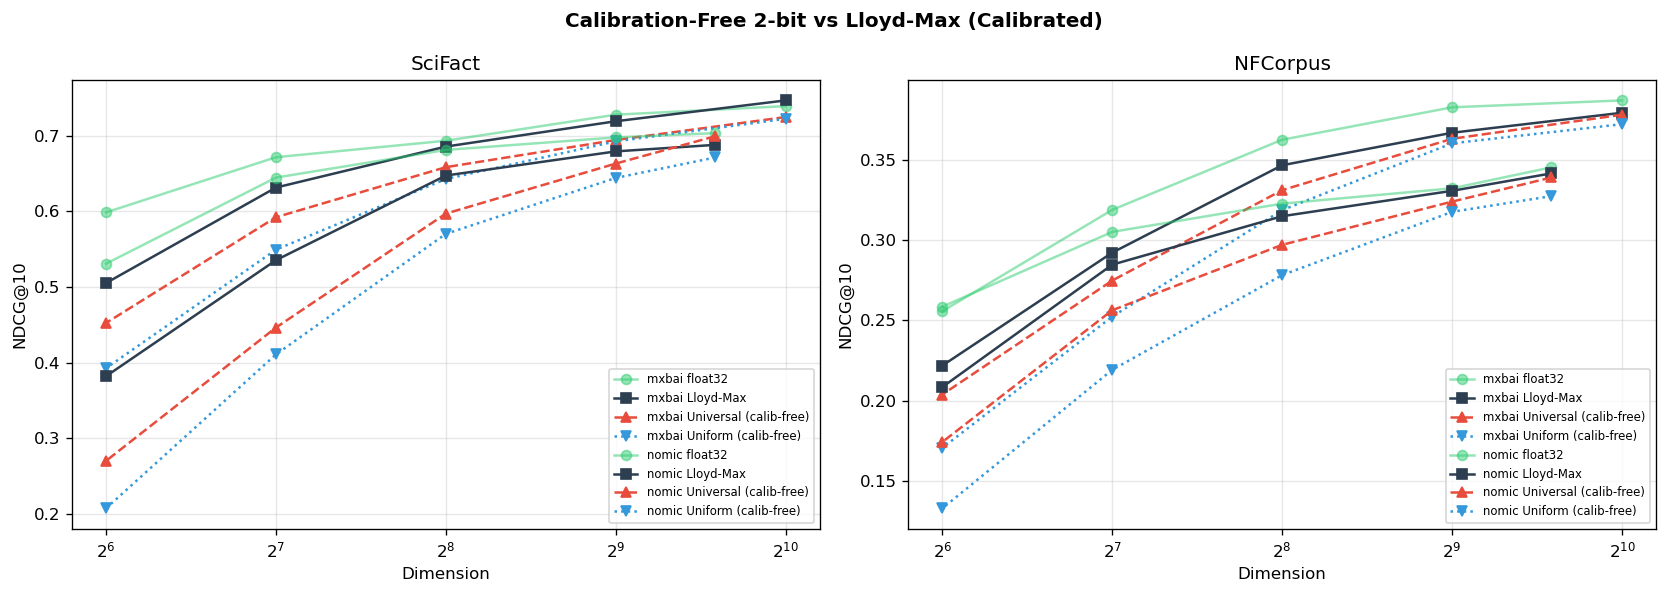


Calibration benefit (Lloyd-Max NDCG − Universal NDCG):
Model      Dataset      Dim  Lloyd-Max  Universal     Gap
───────────────────────────────────────────────────────
mxbai      SciFact     1024     0.7465     0.7245 +0.0220
mxbai      SciFact      512     0.7190     0.6942 +0.0248
mxbai      SciFact      256     0.6855     0.6582 +0.0272
mxbai      SciFact      128     0.6313     0.5921 +0.0392
mxbai      SciFact       64     0.5050     0.4523 +0.0528
mxbai      NFCorpus    1024     0.3792     0.3779 +0.0012
mxbai      NFCorpus     512     0.3667     0.3630 +0.0037
mxbai      NFCorpus     256     0.3465     0.3310 +0.0155
mxbai      NFCorpus     128     0.2921     0.2748 +0.0174
mxbai      NFCorpus      64     0.2219     0.2039 +0.0180
nomic      SciFact      768     0.6878     0.6991 -0.0114
nomic      SciFact      512     0.6791     0.6630 +0.0161
nomic      SciFact      256     0.6472     0.5969 +0.0503
nomic      SciFact      128     0.5353     0.4462 +0.0891
nomic      SciFact

In [16]:
# Plot: How much does calibration-free lose vs Lloyd-Max?
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Calibration-Free 2-bit vs Lloyd-Max (Calibrated)', fontweight='bold')

for ax, ds in zip(axes, DATASETS):
    for mkey, (mname, full_dim, mat_dims) in MODELS.items():
        if len(mat_dims) <= 1:
            continue
        rows = [(d, f32, lm, uni, uf) for mk, dsn, d, f32, lm, uni, uf in calib_free_results
                if mk == mkey and dsn == ds]
        if not rows:
            continue
        dims = [r[0] for r in rows]
        f32s = [r[1] for r in rows]
        lms = [r[2] for r in rows]
        unis = [r[3] for r in rows]
        ufs = [r[4] for r in rows]
        
        ax.plot(dims, f32s, 'o-', color='#2ecc71', label=f'{mkey} float32', alpha=0.5)
        ax.plot(dims, lms, 's-', color='#2c3e50', label=f'{mkey} Lloyd-Max')
        ax.plot(dims, unis, '^--', color='#e74c3c', label=f'{mkey} Universal (calib-free)')
        ax.plot(dims, ufs, 'v:', color='#3498db', label=f'{mkey} Uniform (calib-free)')
    
    ax.set_xlabel('Dimension')
    ax.set_ylabel('NDCG@10')
    ax.set_title(ds)
    ax.set_xscale('log', base=2)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary: how much does calibration buy you?
print('\nCalibration benefit (Lloyd-Max NDCG − Universal NDCG):')
print(f"{'Model':<10} {'Dataset':<10} {'Dim':>5} {'Lloyd-Max':>10} {'Universal':>10} {'Gap':>7}")
print('─' * 55)
for mkey, ds, dim, f32, lm, uni, uf in calib_free_results:
    gap = lm - uni
    print(f"{mkey:<10} {ds:<10} {dim:>5} {lm:>10.4f} {uni:>10.4f} {gap:>+7.4f}")

---
## Summary & Conclusions

Collect the key findings from all experiments.

In [17]:
print('=' * 80)
print('SUMMARY OF FINDINGS')
print('=' * 80)

print('\n1. DISTRIBUTION ANALYSIS')
print('─' * 40)
for mkey, (mname, full_dim, _) in MODELS.items():
    for ds in DATASETS:
        r = all_results.get((mkey, ds, full_dim))
        if r:
            kurt = r['kurtosis_mean']
            deviation = abs(kurt - 3.0)
            assessment = 'Near-Gaussian' if deviation < 0.5 else ('Heavy-tailed' if kurt > 3 else 'Light-tailed')
            print(f'  {mkey}/{ds}: kurtosis={kurt:.2f} ({assessment}), '
                  f'|median| RMS={r["median_offset_rms"]:.4f}, '
                  f'Shapiro reject={r["shapiro_reject_frac"]:.0%}')

print('\n2. BOOTSTRAP CONFIDENCE INTERVALS')
print('─' * 40)
for name, bs in [('mxbai/SciFact', bootstrap_mxbai_scifact), ('mxbai/NFCorpus', bootstrap_mxbai_nfco)]:
    diff = bs['lloyd_max_gauss'] - bs['float32']
    ci_lo, ci_hi = np.percentile(diff, [2.5, 97.5])
    sig = 'SIGNIFICANT' if (ci_lo > 0 or ci_hi < 0) else 'NOT significant'
    print(f'  {name}: Lloyd-Max − Float32 = {np.mean(diff):+.4f} '
          f'[{ci_lo:+.4f}, {ci_hi:+.4f}] → {sig}')

print('\n3. CORRELATION STRUCTURE')
print('─' * 40)
print('  (See PCA vs Matryoshka and correlation heatmap plots above)')

print('\n4. MSE vs RANKING')
print('─' * 40)
mses_all = [p[0] for p in mse_ndcg_points]
taus_all = [p[1] for p in mse_ndcg_points]
r_val, _ = stats.pearsonr(mses_all, taus_all)
print(f'  Score MSE vs Kendall τ correlation: r = {r_val:.3f}')
print(f'  → MSE {"IS" if abs(r_val) > 0.7 else "is NOT"} a reliable proxy for ranking quality')

print('\n5. CALIBRATION-FREE 2-BIT')
print('─' * 40)
gaps = [lm - uni for _, _, _, _, lm, uni, _ in calib_free_results]
print(f'  Mean gap (Lloyd-Max − Universal): {np.mean(gaps):+.4f}')
print(f'  Max gap: {np.max(gaps):+.4f}')
print(f'  → Calibration {"matters significantly" if np.mean(gaps) > 0.01 else "provides marginal benefit"}')

print('\n' + '=' * 80)

SUMMARY OF FINDINGS

1. DISTRIBUTION ANALYSIS
────────────────────────────────────────
  mxbai/SciFact: kurtosis=3.00 (Near-Gaussian), |median| RMS=0.0228, Shapiro reject=55%
  mxbai/NFCorpus: kurtosis=3.08 (Near-Gaussian), |median| RMS=0.0242, Shapiro reject=60%
  nomic/SciFact: kurtosis=3.01 (Near-Gaussian), |median| RMS=0.0282, Shapiro reject=52%
  nomic/NFCorpus: kurtosis=3.14 (Near-Gaussian), |median| RMS=0.0283, Shapiro reject=45%
  minilm/SciFact: kurtosis=nan (Light-tailed), |median| RMS=0.0190, Shapiro reject=52%
  minilm/NFCorpus: kurtosis=nan (Light-tailed), |median| RMS=0.0240, Shapiro reject=60%

2. BOOTSTRAP CONFIDENCE INTERVALS
────────────────────────────────────────
  mxbai/SciFact: Lloyd-Max − Float32 = +0.0077 [-0.0049, +0.0214] → NOT significant
  mxbai/NFCorpus: Lloyd-Max − Float32 = -0.0077 [-0.0135, -0.0019] → SIGNIFICANT

3. CORRELATION STRUCTURE
────────────────────────────────────────
  (See PCA vs Matryoshka and correlation heatmap plots above)

4. MSE vs RAN